In [2]:
# import libraries
from sklearn.datasets import fetch_openml

# load dataset
mnist = fetch_openml('mnist_784', as_frame=False)

In [3]:
# create features and targets
X, y = mnist.data, mnist.target
#review
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [4]:
X.shape # 70000 images with 784 features = 28 * 28 pixels

(70000, 784)

In [5]:
y.shape

(70000,)

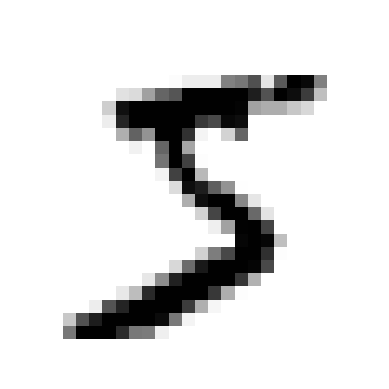

In [8]:
# look at one digit
import matplotlib.pyplot as plt

def plot_image(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_image(some_digit)
plt.show()

In [9]:
# verify what target is 
y[0]

'5'

In [11]:
# manually split training and testing data
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

##### Begin Training a Binary Classifier

In [12]:
# create target vector for 5
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [16]:
# import stochastic gradient descent model
from sklearn.linear_model import SGDClassifier

# create and fit model
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

# predict if our digit from earlier is 5
pred_5 = sgd_clf.predict([some_digit])
print(pred_5)

[ True]


##### Get Performance Measures

In [17]:
from sklearn.model_selection import cross_val_score
print(cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy"))

[0.95035 0.96035 0.9604 ]


This model is ~95% accurate on the training data. It seems overfit. How can we ge sure this is real and not do to a data imbalance or somethin else.

In [19]:
# test using a dummy classifier
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train))) # if no 5s detected it will print false
print(cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy"))

False
[0.90965 0.90965 0.90965]


Just guessing not 5 every time will give you an accuracy of 90% due to only 10% of the data being actual 5s.

##### Confusion Matrix Metric

In [20]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics  import confusion_matrix

# create training prediction
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

# create confusion matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [22]:
# create perfect predictions
y_train_perfect_pred = y_train_5
# show what a confusion matrix would look like with perfect predictions
cm_perf = confusion_matrix(y_train_5, y_train_perfect_pred)
cm_perf

array([[54579,     0],
       [    0,  5421]], dtype=int64)

##### Precision and Recall

Accuracy of positive predictions is called precision

$P = \frac{TP}{TP+FP}$

Sensitivity or Recall is the ratio of positive instances correctly detected by the classifier

$recall = \frac{TP}{TP+FN}$

In [24]:
# sklearn has packages for this
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)
print("precision score = %f" %(precision))
print("recall score = %f" %(recall))

precision score = 0.837088
recall score = 0.651171


Not actually as good as 95% accuracy. We can see precision and recall are lower than the plain accuracy of our classifier.

##### F1 - Score

$F_{1} = \frac{2}{\frac{1}{precision} + \frac{1}{recall}}\times \frac{precision\times recall}{precision + recall} = \frac{TP}{TP + \frac{FN + FP}{2}}$

Combination of both precision and recall. This is the *harmonic mean* of precision and recall. This gives more weight to lower values meaning a high F1 score is only possible if both the precision and recall are both high.

In [25]:
# compute F1 score
from sklearn.metrics import f1_score
print("F1 score is %f" %(f1_score(y_train_5, y_train_pred)))

F1 score is 0.732517


This is a more accurate reflection of how well our model performs. 

#####  Precision/Recall Tradeoff

In [27]:
# look at the decision function
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred # will the score be greater than the threshold for detection

[2164.22030239]


array([ True])

In [28]:
# if we set a higher threshold what will happen
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [34]:
from sklearn.metrics import precision_recall_curve

# modify our cross val score to use decision functions instead of accuracy
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

# get thresholds, precisions and recalls
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

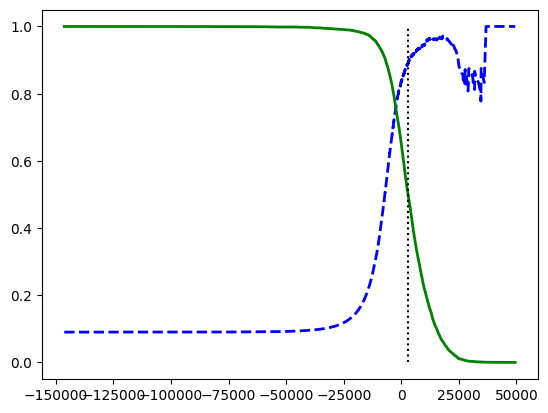

In [35]:
# Plot the precision recall curve
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
plt.show()

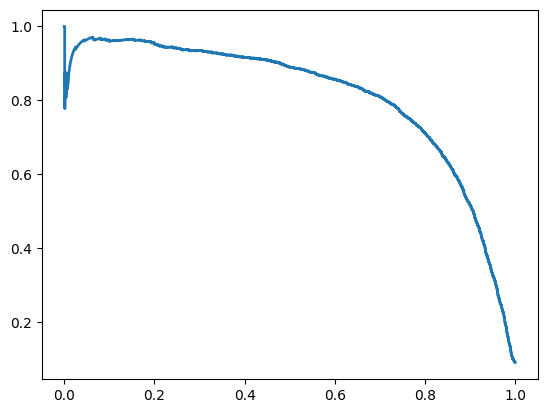

In [36]:
# plot the precision against recall
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")